# Home Assignment No. 3: Part 1 (Theory and Practice)
To solve this task, you will write a lot of code to try several machine learning methods for dimensionality reduction and anomaly detection.
* You are **HIGHLY RECOMMENDED** to read relevant documentation, e.g. for [python](https://docs.python.org/3/), [numpy](https://docs.scipy.org/doc/numpy/reference/), [matlpotlib](https://matplotlib.org/) and [sklearn](https://scikit-learn.org/stable/). Also remember that seminars, lecture slides, [Google](http://google.com) and [StackOverflow](https://stackoverflow.com/) are your close friends during this course (and, probably, whole life?).

* If you want an easy life, you have to use **BUILT-IN METHODS** of `sklearn` library instead of writing tons of your own code. There exists a class/method for almost everything you can imagine (related to this homework).

* To do this part of homework, you have to write **CODE** directly inside specified places inside notebook **CELLS**.

* In some problems you are asked to provide short discussion of the results. In these cases you have to create **MARKDOWN** cell with your comments right after the corresponding code cell.

* For every separate problem you can get only 0 points or maximal points for this problem. There are **NO INTERMEDIATE scores**. So make sure that you did everything required in the task

* Your **SOLUTION** notebook **MUST BE REPRODUCIBLE**, i.e. if the reviewer decides to execute all, after all the computation he will obtain exactly the same solution (with all the corresponding plots) as in your uploaded notebook. For this purpose, we suggest to fix random `seed` or (better) define `random_state=` inside every algorithm that uses some pseudorandomness.

* Your code must be clear to the reviewer. For this purpose, try to include neccessary comments inside the code. But remember: **GOOD CODE MUST BE SELF-EXPLANATORY** without any additional comments.

* Many `sklearn` algorithms support multithreading (Ensemble Methods, Cross-Validation, etc.). Check if the particular algorithm has `n_jobs` parameters and set it to `-1` to use all the cores.

## Task 1. Practice with Different Anomaly Detection Algorithms. (5 points)
### Task 1.1. (1 point)
Explore two One-Class SVM methods, write down corresponding minimization functions (try to keep equal notations) and explain the differences (1-2 sentences).
1. Scholkopf et al.: http://papers.nips.cc/paper/1723-support-vector-method-for-novelty-detection.pdf
2. Tax et al.:  https://link.springer.com/content/pdf/10.1023/B:MACH.0000008084.60811.49.pdf

### Solution
#### Scholkopf et al.
$$
\min_{w \in F, \xi \in \mathbb{R}^l, \rho \in \mathbb{R}} \frac{1}{2} ||w||^2 + \frac{1}{v l} \sum_{i} \xi_i - \rho, \\
\text{subject to } (w \cdot \Phi(x_i)) \geq \rho - \xi_i, \xi_i \geq 0.
$$

#### Tax et al.
$$
\min_{R \in \mathbb{R}, \xi \in \mathbb{R}^l} R^2 + C \sum_i \xi_i, \\
\text{subject to } ||x_i - a_i||^2 \leq R^2 + \xi_i, \xi_i \geq 0.
$$

I think the main difference is that in the second work the compact to bound all of the data is set to be the hypersphere, so we've got a strong restriction on the solution geometry. However, in the first work any mapping $\Phi$ (which can generate a kernel) can be picked, which gives us potentially more flexible model.

### Task 1.2. (2 points)

1. **(1 pt.)** For the `frod_detection` dataset,  predict the anomaly with any three sklearn built-in Anomaly detection methods: https://scikit-learn.org/stable/modules/outlier_detection.html

**Note:** do not forget to relabel predictions from Anomaly detection methods, as they could be negative.

2. **(1 pt.)** Estimate the __contamination__ (or impurity) on the training set as the ratio of anomaly objects in the whole sample. Explore, how the `roc_auc_score` changes with `contamination` value, taking a grid `[0.1*contamination, 1*contamination, 10*contamination]`. Point out the best performing algorithm.

In [7]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.xkcd()

from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score
from sklearn.svm import OneClassSVM

from sklearn.cluster import KMeans, Birch, AffinityPropagation, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, mutual_info_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, silhouette_score, mutual_info_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

data = pd.read_csv('data/creditcard.csv')

X = data.drop(columns="Class")
y = data["Class"]

# keep the split fixed
tt_split = train_test_split(X, y, test_size = 0.1, stratify=y, random_state= 42)
train_X, test_X, train_y, test_y = tt_split 

# delete the targets for training
train_y = 0

# replace values
test_y = test_y.replace({0 : 1, 1 : -1})

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')
(26031, 30)


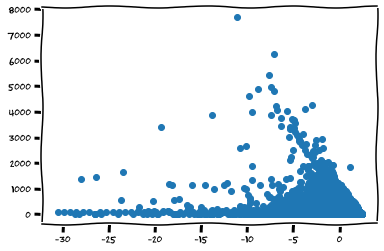

In [2]:
print(train_X.columns)
print(train_X.shape)
plt.scatter(train_X['V1'], train_X['Amount'])

In [3]:
def run_detector(model, X_train, X_test, y_test, contamination):
    if model == IsolationForest:
        detector = model(contamination=contamination, n_jobs=-1)
    elif model == EllipticEnvelope:
        detector = model(contamination=contamination, support_fraction=1)
    else:
        detector = model(contamination=contamination)
    detector.fit(X_train)
    roc_auc = roc_auc_score(y_test, detector.predict(X_test))
#     print(f'accuracy {roc_auc:.2f} was reached for contamination {contamination:.2f}')
    return roc_auc

def search(model, X_train, X_test, y_test, params):
    roc_auc_list = []
    for cont in params['contamination']:
        roc_auc_list.append(run_detector(model, X_train, X_test, y_test, cont))
    return params['contamination'][np.argmax(roc_auc_list)], max(roc_auc_list)
    
prior_contamination = 1 / 500
models = [EllipticEnvelope, IsolationForest, OneClassSVM]
conts = np.logspace(-1, 2, 30) * prior_contamination
best_cov_params = search(EllipticEnvelope, train_X, test_X, test_y, {'contamination' : conts})
best_forest_params = search(IsolationForest, train_X, test_X, test_y, {'contamination' : conts})
best_svm_params = (None, roc_auc_score(test_y, OneClassSVM().fit(train_X).predict(test_X)))

In [4]:
print(best_cov_params)
print(best_forest_params)
print(best_svm_params)

(0.15760925631339825, 0.8681004047188494)
(0.15760925631339825, 0.8770738253107151)
(None, 0.5357142857142857)


In [5]:
# from sklearn.ensemble import # >>> your solution here <<<

for i in [0.1, 1, 10, 70]:
    
    # >>> your solution here <<<
    detector = IsolationForest(contamination=prior_contamination * i, n_jobs=-1)
    detector.fit(train_X)
    labels_isolation = detector.predict(test_X)
 
    print('Contamination: ', np.round(prior_contamination * i, 3), ' ', 
          'ROC/AUC: ', np.round(roc_auc_score(test_y, labels_isolation), 3),
          'Precision: ', np.round(precision_score(test_y, labels_isolation, average = 'micro'), 3)) #changed average to macro

Contamination:  0.0   ROC/AUC:  0.51 Precision:  0.983
Contamination:  0.002   ROC/AUC:  0.531 Precision:  0.984
Contamination:  0.02   ROC/AUC:  0.761 Precision:  0.984
Contamination:  0.14   ROC/AUC:  0.867 Precision:  0.876


### Comments
We see that in terms of roc_auc robust covariance model and isolation forest show almost the same results with some contamination parameters. However, if we study presision score alongside roc auc, we'll see that precision doesn't monotonously grow on the same values of contamination as roc auc does.

### Task 1.3. (2 points)

The idea is to see when anomaly detection methods, trained with no labels, can facilitate the prediction of the classifier. Imagine a real case scenario: you have labelled only a small portion of the dataset and a bunch of unlabeled data. We will simulate the situation when __90%__ of data is unlabeled and we still desire to achieve good performance.

As you can score your predictions only on the __10%__ of the sample, you better do it in cross validation to ensure the model stability.
1. **(1 pt.)** Take your favorite classifier and estimate the performance on __test set__ using `StratifiedKFold(n_splits=10, random_state = 42)` with `roc_auc` and `precision_score`. You can use test set upsampling and other instruments to enforce your prediction. 
2. **(1 pt.)**  Try to enhance the classifier performance in  `roc_auc` or `precision_score` (or ideally both), building the ensemble, using __Anomaly detection__ methods from the previous task. You can fit __Anomaly detection__ methods on both  __training set__ and subset from __test set__ on the cross-validation fold. Write 1-2 sentences on your findings.

__NOTE:__ try not to overfit, thus not adjust the `contamination` while training, and refit classifiers on each fold. 

__Hints:__ `sklearn.ensemble.VotingClassifier` does not support Anomaly detection methods, so you are to write it yourself. And `np.logical_and` or `np.logical_or` will suit for the trivial ensemble.

In [6]:
# your favorite classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
skf.get_n_splits(test_X, test_y)

roc_auc_scores = []
pr_scores = []

for train_index, test_index in skf.split(test_X, test_y):
    # >>> your solution here <<<
    clf = LogisticRegression(max_iter=1337)
    clf.fit(test_X.iloc[train_index], test_y.iloc[train_index])
    preds = clf.predict(test_X.iloc[test_index])
    roc_auc_scores.append(roc_auc_score(test_y.iloc[test_index], preds))
    pr_scores.append(precision_score(test_y.iloc[test_index], preds))
    
print('ROC/AUC mean: ', np.mean(roc_auc_scores), 'std: ', np.std(roc_auc_scores))    
print('Precision mean: ', np.mean(pr_scores), 'std: ', np.std(pr_scores))

ROC/AUC mean:  0.8567957746478874 std:  0.09112293050923219
Precision mean:  0.9951011457266207 std:  0.0031870331254420336


In [7]:
# ensemble of classifiers
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
skf.get_n_splits(test_X, test_y)

roc_auc_scores = []
pr_scores = []

cov = EllipticEnvelope(contamination=best_cov_params[0], support_fraction=1)
ifc = IsolationForest(contamination=best_forest_params[0], random_state=42)

for train_index, test_index in skf.split(test_X, test_y):
    # >>> your solution here <<<
    clf = LogisticRegression(max_iter=1337)
    clf.fit(test_X.iloc[train_index], test_y.iloc[train_index])
    clf_preds = clf.predict(test_X.iloc[test_index])
    anomaly_preds = np.zeros(len(test_index), dtype=int)
    for model in [cov, ifc]:
        model.fit(pd.concat([train_X, test_X.iloc[train_index]], axis=0))
        anomaly_preds |= model.predict(test_X.iloc[test_index])
    preds = clf_preds & anomaly_preds
    roc_auc_scores.append(roc_auc_score(test_y.iloc[test_index], preds))
    pr_scores.append(precision_score(test_y.iloc[test_index], preds))
    
print('ROC/AUC mean: ', np.mean(roc_auc_scores), 'std: ', np.std(roc_auc_scores))    
print('Precision mean: ', np.mean(pr_scores), 'std: ', np.std(pr_scores))

ROC/AUC mean:  0.8567957746478874 std:  0.09112293050923219
Precision mean:  0.9951011457266207 std:  0.0031870331254420336


### Write 1-2 sentences on your findings.
Firstly I've tried to use random forest classifier (you said favourite!) but even with 10 estimators the results are getting worse while trying to combine it with detectors. It happens because random forest itself is a strong classifier. When I switched to logreg, I can finally see tiiiiiiiiny improvement in the result if we're speaking about roc auc. We can constrain logreg even more, bu7 1 w0n'7 d0 7h47.

## Task 2. Practice with Different Clustering Algorithms. (4 points)
### Task 2.1. Explore KMeans and Gaussian Mixture algorithms. (2 points)
Try **KMeans, Gaussian Mixture** and **two** more clustering algorithms from sklearn. 
To evaluate clustering performance use **two** clustering metrics: *silhouette score*
and *mutual information* or *adjusted mutual information*.

For each algorithm **your task** is to try to find the parameters leading to the best performance for `n_clusters=true_number_of_clusters`:
1. **(1 pt.)** Apply the algorithm with the true number of clusters and at least two **other settings** for the number of clusters: a smaller and a larger number than the true one;
2. **(1 pt.)** For each number of clusters **vizualize the clustering result**, calculate the **clustering metrics** and plot them;

__NOTE:__ `sklearn.model_selection.GridSearchCV` does not support clustering methods, thus you suppose to do it manually.

True number of clusters is 15


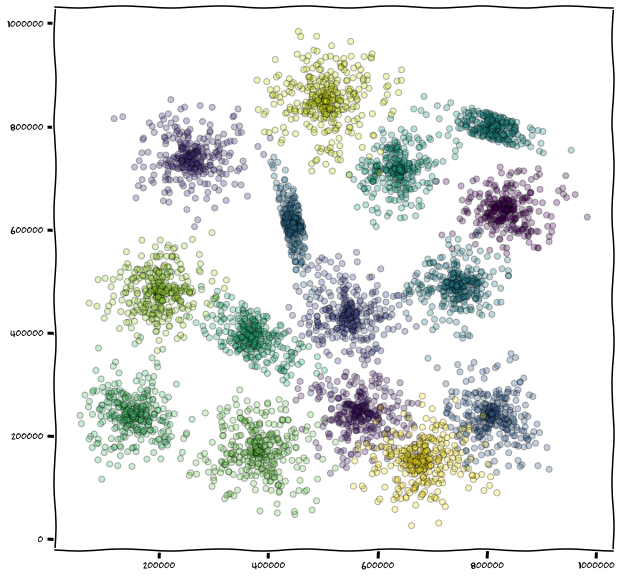

In [8]:
points, labels = np.loadtxt('data/clustering.txt'), np.loadtxt('data/clustering_labels.txt')
labels = labels.astype(int)
print("True number of clusters is {}".format(np.max(labels)))
plt.figure(figsize=(10, 10))
plt.scatter(points[:,0], points[:,1], c=labels, alpha=0.3, edgecolor='k')

plt.show()

/home/topshik/.local/lib/python3.6/site-packages/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (14) by Birch is less than (15). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/topshik/.local/lib/python3.6/site-packages/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (14) by Birch is less than (19). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


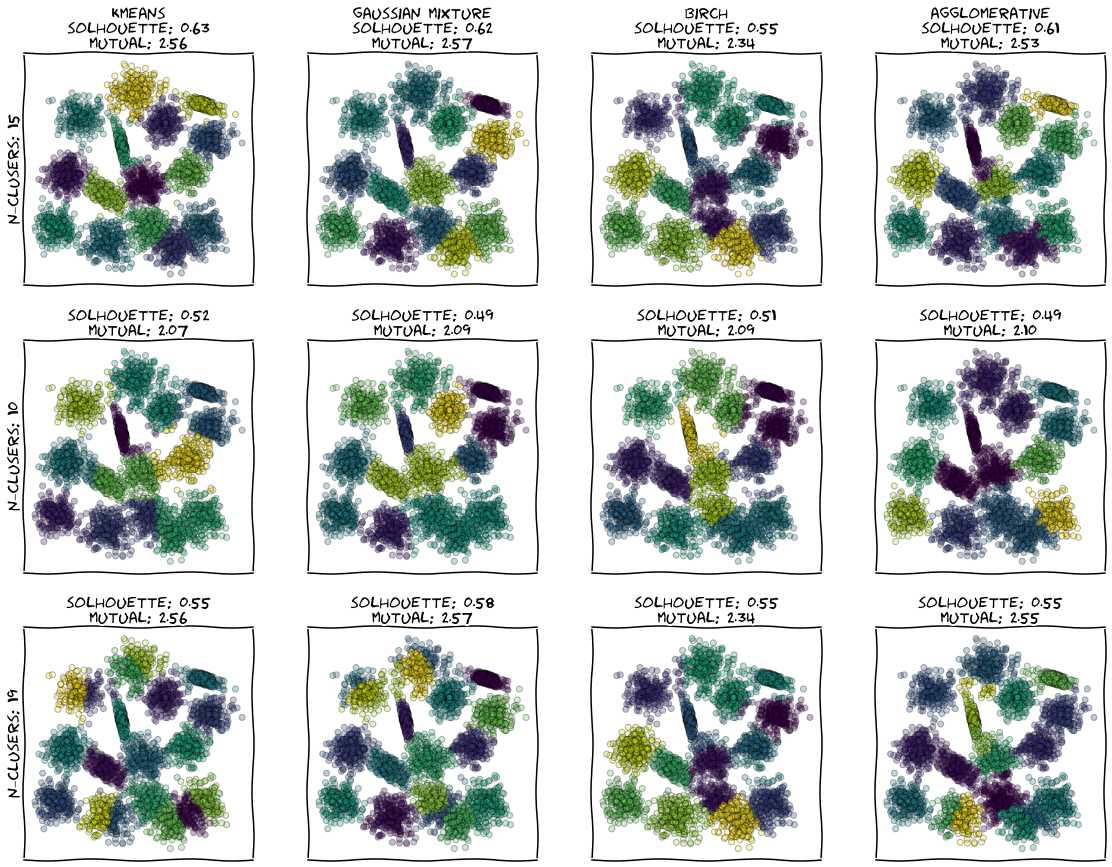

In [9]:
# Apply the algorithm with the true number of clusters and at least two other
# settings for the number of clusters: a smaller and a larger number than the true one;
# vizualize the clustering result

### BEGIN Solution
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams['axes.labelsize'] = 16
plt.xkcd()

scaler = StandardScaler()
points = scaler.fit_transform(points)

n_clusters_true = int(np.max(labels))

models = []
models_names = ['kmeans', 'gaussian mixture', 'birch', 'agglomerative']
n_clusters_list = [n_clusters_true, int(n_clusters_true * 0.7), int(n_clusters_true * 1.3)]

for i, n_clusters in enumerate(n_clusters_list):
    kmeans = KMeans(n_clusters=n_clusters, n_jobs=-1)
    gauss = GaussianMixture(random_state=42, n_components=n_clusters)
    birch = Birch(n_clusters=n_clusters, copy=False)
    agglo = AgglomerativeClustering(n_clusters=n_clusters)
    curr_models_set = [kmeans, gauss, birch, agglo]
    for model in curr_models_set:
        model.fit(points)
    models.append(curr_models_set)

fig, axs = plt.subplots(3, 4, figsize=(16, 12))
fig.tight_layout(w_pad=1.0, h_pad=2.0)
for i, mdl_set in enumerate(models):
    for j, mdl in enumerate(mdl_set):
        axs[i][j].tick_params(bottom=False, top=False, left=False, right=False, 
                              labelbottom=False, labelleft=False)
        if j == 1:
            preds = mdl.predict(points)
            axs[i][j].scatter(points[:,0], points[:,1], c=preds, alpha=0.3, edgecolor='k')
            axs[i][j].set_title(f'silhouette: {silhouette_score(points, preds):.2f}\nmutual: {mutual_info_score(labels, preds):.2f}', fontsize=16)
        else:
            axs[i][j].scatter(points[:,0], points[:,1], c=mdl.labels_, alpha=0.3, edgecolor='k')
            axs[i][j].set_title(f'silhouette: {silhouette_score(points, mdl.labels_):.2f}\nmutual: {mutual_info_score(labels, mdl.labels_):.2f}', fontsize=16)
        if i == 0:
            axs[i][j].set_title(models_names[j] + '\n' + axs[i][j].title._text, fontsize=16)
        if j == 0:
            axs[i][j].set_ylabel(f'n_clusers: {n_clusters_list[i]}', fontsize=16)
        
plt.show()
### END Solution

/home/topshik/.local/lib/python3.6/site-packages/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (14) by Birch is less than (15). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/topshik/.local/lib/python3.6/site-packages/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (14) by Birch is less than (17). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/topshik/.local/lib/python3.6/site-packages/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (14) by Birch is less than (18). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/topshik/.local/lib/python3.6/site-packages/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (14) by Birch is less than (20). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/topshik/.local/lib

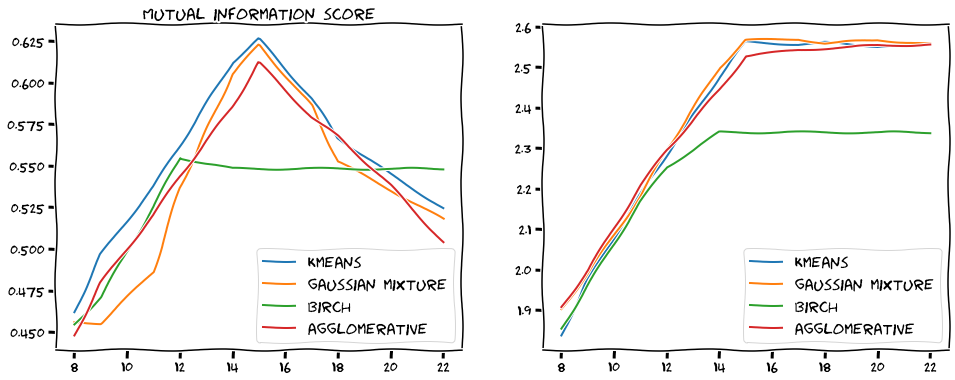

In [10]:
# calculate the clustering metrics and plot them;
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

n_clusters_list = list(map(int, np.linspace(8, 22, 10)))
models_set = [KMeans(), GaussianMixture(), Birch(), AgglomerativeClustering()]
models_names = ['kmeans', 'gaussian mixture', 'birch', 'agglomerative']

for i, model in enumerate(models_set):
    model_silh = []
    model_mutual = []
    for j, n_clusters in enumerate(n_clusters_list):
        if i == 1:
            model.set_params(**{'n_components' : n_clusters})
        elif i == 2:
            model.set_params(**{'n_clusters' : n_clusters, 'copy' : False})
        else:
            model.set_params(**{'n_clusters' : n_clusters})
        preds = model.fit_predict(points)
        silh = silhouette_score(points, preds)
        mutual = mutual_info_score(labels, preds)
        model_silh.append(silh)
        model_mutual.append(mutual)
    axs[0].plot(n_clusters_list, model_silh, label=models_names[i])
    axs[1].plot(n_clusters_list, model_mutual, label=models_names[i])
    axs[0].legend(fontsize=16)
    axs[1].legend(fontsize=16)
    axs[0].set_title('Solhouette score')
    axs[0].set_title('Mutual information score')

### Task 2.2. Finding the Number of Clusters with Bootstrap. (2 points)
For a chosen algorithm find the best number of clusters using bootstrap. Based on your observations made at previous task, choose one algorithm assuming **you do not have true labels and do not know the true number of clusters**.
1. **(1 pt.)** Estimate variance of the metric and construct normal 95% **confidence interval (CI)**;
2. **(1 pt.)** **Plot the metric** with the corresponding confidence intervals and show the best number of clusters.

__Hints:__  
- you can choose bootstrap samples with any size, and sample number starting from `50`;
- you can use `scipy.stats.norm.interval()` to derive CI;

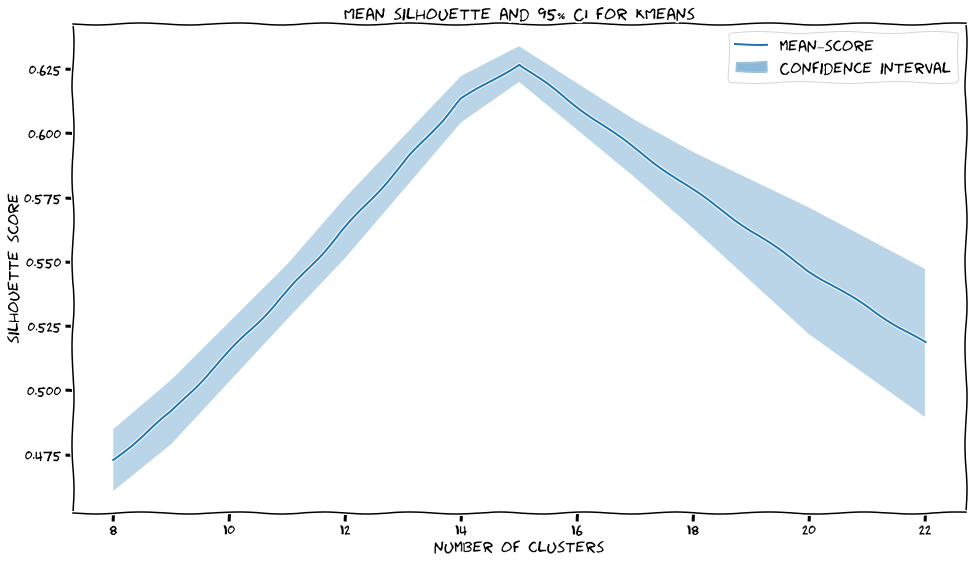

In [11]:
import scipy

from tqdm.notebook import tqdm

### BEGIN Solution

cluster_ns = list(map(int, np.linspace(8, 22, 10))) # >>> your solution here <<<
sample_number = 50 # >>> your solution here <<<

means = []
variances = []
kmeans = KMeans(n_jobs=-1)

for i, n_clusters in enumerate(tqdm(cluster_ns)):
    # >>> your solution here <<<
    kmeans.set_params(**{'n_clusters' : n_clusters})
    scores = []
    for _ in range(sample_number):
        data_ix = np.random.choice(points.shape[0], points.shape[0], replace=True)
        scores.append(silhouette_score(points[data_ix], kmeans.fit_predict(points[data_ix])))
    means.append(np.mean(scores))
    variances.append(np.var(scores))
    
interval = scipy.stats.norm(means, np.sqrt(np.array(variances))).interval(0.95)

plt.title('Mean silhouette and 95% CI for KMeans')
plt.xlabel('number of clusters')
plt.ylabel('silhouette score')
plt.plot(cluster_ns, means, label='mean_score')
plt.fill_between(cluster_ns, *interval, alpha=0.3, label='Confidence interval')
plt.legend()
plt.show()
    
### END Solution

## Task 3. MNIST, kMNIST component analysis and manifold learning. (6 points)
### Task 3.1. (2 points)

Download `MNIST` dataset. Here we will estimate the data intrinsic dimentionality, decompose the dataset on pinciple components and estimate the cumulative explained variance by each component.

You can either use the [proposed method](https://www.stat.berkeley.edu/~bickel/mldim.pdf) for the estimation of sample intrinsic dimension or any other method (convenient for you). For the first case use can use the code from [here](https://gist.github.com/mehdidc/8a0bb21a31c43b0cbbdd31d75929b5e4)

1. **(1 pt.)** Estimate the intrinsic dimentionality of the dataset. Provide the plot.
2. **(1 pt.)** Decompose the data on principal components (PCA). Plot the cumulative explained variance by each component. Plot the example of back-decomposition with **6** different set of components and corresponding explained variance. You can choose any digit from the dataset.

In [8]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import seaborn as sns

sns.set()

dg = datasets.load_digits()

scaler = StandardScaler()
data = scaler.fit_transform(dg.data)

In [13]:
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
 
def intrinsic_dim_sample_wise(X, k=5):
    neighb = NearestNeighbors(n_neighbors=k+1).fit(X)
    dist, ind = neighb.kneighbors(X) # distances between the samples and points
    dist = dist[:, 1:] # the distance between the first points to first points (as basis ) equals zero
    # the first non trivial point
    dist = dist[:, 0:k]# including points k-1
    assert dist.shape == (X.shape[0], k) # requirments are there is no equal points
    assert np.all(dist > 0)
    d = np.log(dist[:, k - 1: k] / dist[:, 0:k-1]) # dinstanec betveen the bayeasan statistics
    d = d.sum(axis=1) / (k - 2)
    d = 1. / d
    intdim_sample = d
    return intdim_sample
 
def intrinsic_dim_scale_interval(X, k1=10, k2=20):
    X = pd.DataFrame(X).drop_duplicates().values # remove duplicates in case you use bootstrapping
    intdim_k = []
    for k in range(k1, k2 + 1): # in order to reduse the noise by eliminating of the nearest neibours 
        m = intrinsic_dim_sample_wise(X, k).mean()
        intdim_k.append(m)
    return intdim_k
 
def repeated(func, X, nb_iter=100, random_state=None, mode='bootstrap', **func_kw):
    if random_state is None:
        rng = np.random
    else:
        rng = np.random.RandomState(random_state)
    nb_examples = X.shape[0]
    results = []
 
    iters = range(nb_iter) 
    for i in iters:
        if mode == 'bootstrap':# and each point we want to resample with repeating points to reduse the errors 
            #232 111 133 
            Xr = X[rng.randint(0, nb_examples, size=nb_examples)]
        elif mode == 'shuffle':
            ind = np.arange(nb_examples)
            rng.shuffle(ind)
            Xr = X[ind]
        elif mode == 'same':
            Xr = X
        else:
            raise ValueError('unknown mode : {}'.format(mode))
        results.append(func(Xr, **func_kw))
    return results

In [14]:
# Estimate the intrinsic dimentionality of the dataset. 

### BEGIN Solution

# >>> your solution here <<<
intdim_k_repeated = np.array(repeated(intrinsic_dim_scale_interval, data, k1=5, k2=50))
### END Solution

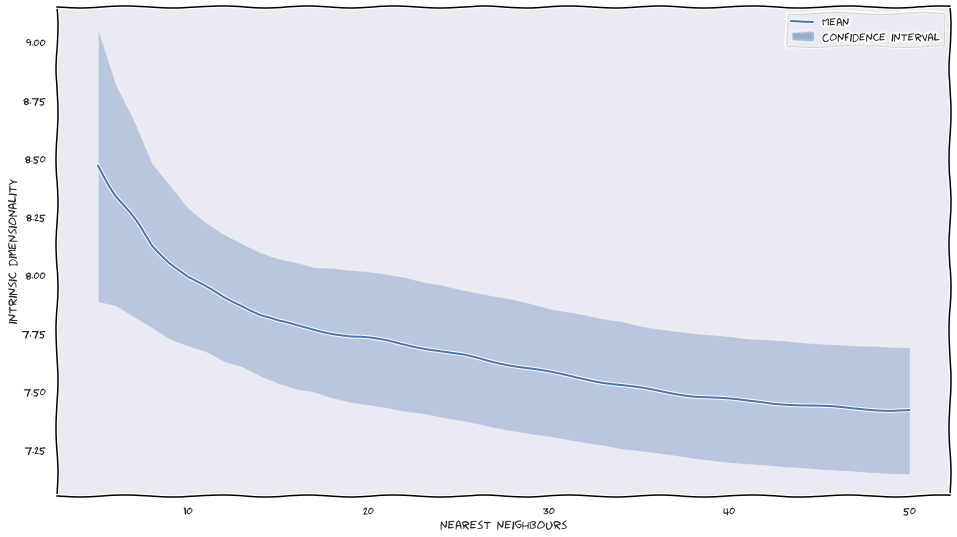

In [15]:
plt.xkcd()
intdim_mean = np.mean(intdim_k_repeated, axis=0)
intdim_var = np.var(intdim_k_repeated, axis=0)
intdim_interval = scipy.stats.norm(intdim_mean, np.sqrt(np.array(intdim_var))).interval(0.95)
plt.plot(np.arange(5, 51), intdim_mean, label='Mean')
plt.fill_between(np.arange(5, 51), *intdim_interval, alpha=0.3, label='Confidence interval')
plt.xlabel('nearest neighbours')
plt.ylabel('intrinsic dimensionality')
plt.legend()
plt.show()

100%|██████████| 65/65 [00:00<00:00, 83.19it/s]


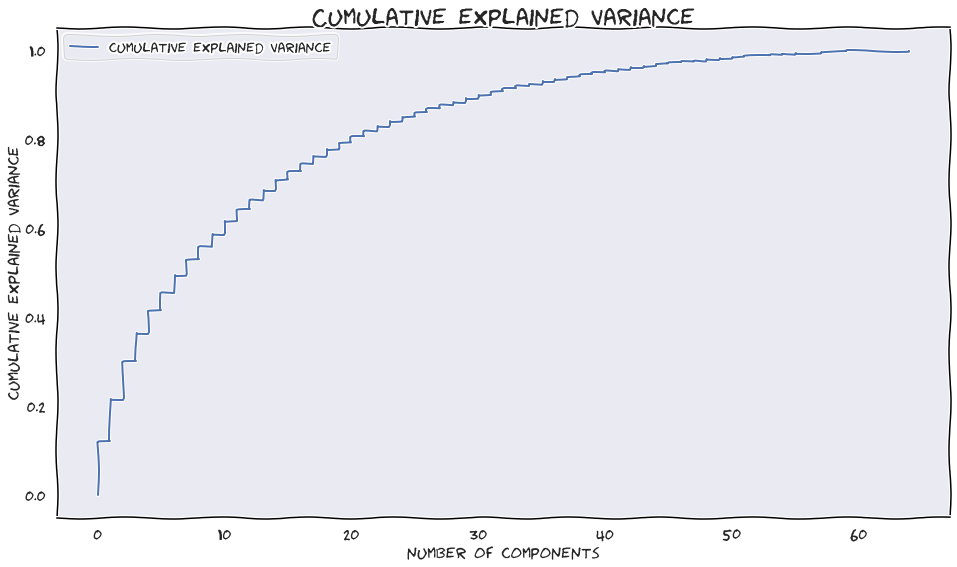

In [16]:
# Decompose the data on principal components (PCA). Plot the cumulative explained variance by each component.
from sklearn.decomposition import PCA

### BEGIN Solution

# >>> your solution here <<<
components_space = np.arange(65)
explained_variance = []
for n_components in tqdm(components_space):
    pca = PCA(n_components=n_components)
    pca.fit(data)
    explained_variance.append(pca.explained_variance_ratio_.sum())
    
plt.step(components_space, explained_variance, label='cumulative explained variance')
plt.title('Cumulative explained variance', fontsize=24)
plt.xlabel('number of components', fontsize=16)
plt.ylabel('cumulative explained variance', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)
plt.show()

### END Solution

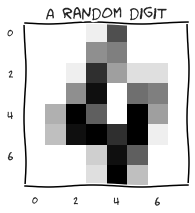

In [17]:
# Plot the example of back-decomposition with 6 different 
# set of components and corresponding explained variance. You can choose any digit from the dataset.
plt.xkcd()
plt.figure(5, figsize=(3, 3))
plt.imshow(dg.images[4], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title('A random digit', fontsize=16)
plt.show()

y = dg.target
X = dg.images.reshape(-1, 8*8) / dg.images.max()

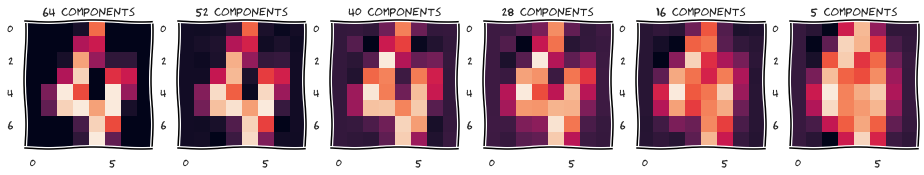

In [18]:
### BEGIN Solution

# >>> your solution here <<<
digit = dg.images[4]
n_components_space = np.linspace(5, 64, 6).astype('int64')

fig, axs = plt.subplots(1, 6, figsize=(16, 5))

for ax, n_components in zip(axs.ravel(), n_components_space[::-1]):
    pca = PCA(n_components=n_components)
    pca.fit(data)
    image_decomposed = pca.inverse_transform(pca.transform(data[4].reshape(1, -1)))
    image = scaler.inverse_transform(image_decomposed)
    ax.set_title(f'{n_components} components')
    ax.imshow(image.reshape(8, 8))

### END Solution

### Task 3.2. (2 points)

Here we will visualise the decomposition in order to observe how data diverges across different manofild learning methods. We are  to compare `PCA`, `ICA` and `Isomap` non-linear decompositions [see more over here https://scikit-learn.org/stable/modules/manifold.html], and check the classification accuracy on the new features. 

1. Visualise ICA, PCA and Isomap 3D decomposition on 3 components in `plotly`. Make sure the data is whitened (scaled), enjoy nice plots :) 
2. **(1 pt.)** Calculate new features on the data with ICA, PCA and Isomap. **Choose the number of components according to your estimation of intrinsic dimention**. Calculate the classification accuracy on these features with `LogisticRegression` on `cross_val=5` with $3$ repeats. Use `RepeatedKFold` and fit the `random_seed = 42`.
3. **(1 pt.)** Show that the `Isomap` gives statistically significant improvement on the classification accuracy with any appropriate statistical test. Provide corresponding `p-values`. Justify your results, write down 2-3 senteces.

__NOTE:__ In first task, `plotly` will not display the plot in offline notebook, so it is just for you to visualize the projection in 3D.

In [4]:
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import colorlover as cl

init_notebook_mode(connected=True)

In [9]:
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import Isomap
### BEGIN Solution

# >>> your solution here <<<

pca = PCA(n_components=3)
S_pca_ = pca.fit_transform(data) # >>> your solution here <<<
ica = FastICA(n_components=3)
S_ica_ = ica.fit_transform(data)
isomap = Isomap(n_components=3)
S_isomap_ = isomap.fit_transform(data)

### END Solution

In [ ]:
def plot_fig(transformed_data, title):
    digits_3d = pd.DataFrame({
        'x': transformed_data[:, 0], 
        'y': transformed_data[:, 1], 
        'z': transformed_data[:, 2],
        'label': dg['target'],
    })

    colors = cl.scales['10']['qual']['Paired']
    data = []

    for i in range(10):
        x = digits_3d[digits_3d['label'].astype('int') == i]['x']
        y = digits_3d[digits_3d['label'].astype('int') == i]['y'] # arrrrrghhhhh we already have variable y!!!
        z = digits_3d[digits_3d['label'].astype('int') == i]['z']

        color = colors[i]

        trace = {
            'name': str(i),
            'x': x,
            'y': y,
            'z': z,
            'type': 'scatter3d',
            'mode': 'markers',
            'marker': {
                'size': 5,
                'color': color 
            }
        }
        data.append(trace)

    layout = go.Layout(
        title='MNIST visualization PCA',
        width=900,
        height=600
    )

    fig = go.Figure(data=data, layout=layout)

    iplot(fig, show_link = False)
    
plot_fig(S_pca_, 'MNIST visualization PCA')
plot_fig(S_ica_, 'MNIST visualization ICA')
plot_fig(S_isomap_, 'MNIST visualization Isomap')

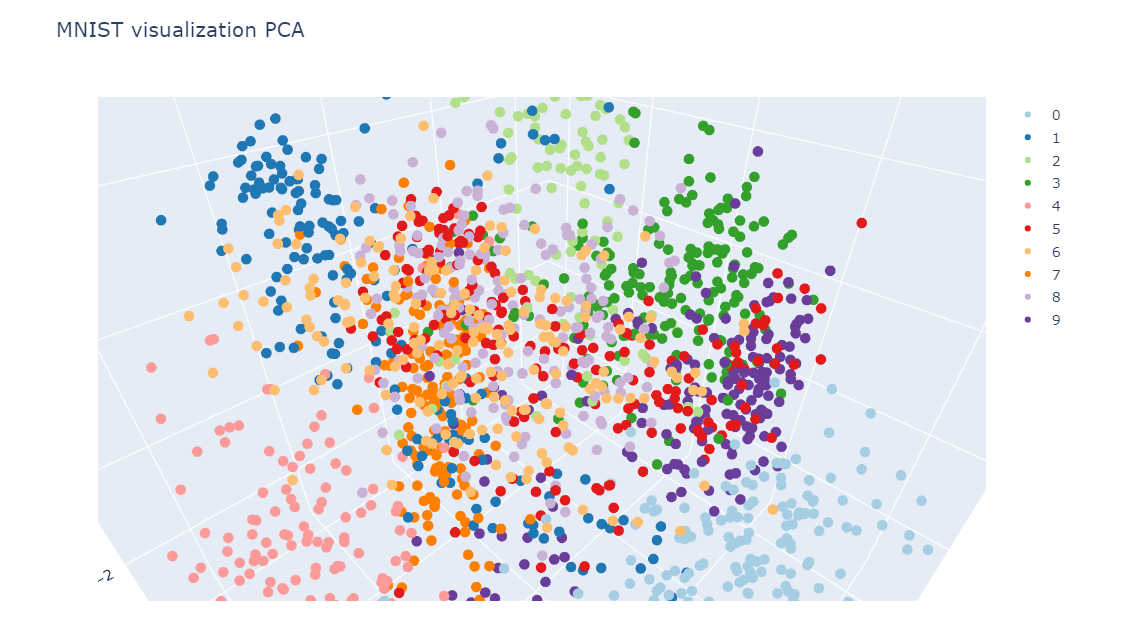

In [22]:
from IPython.display import Image
Image("pca.png")

In [28]:
# Calculate new features on the data with ICA, PCA and Isomap and the classification accuracy on these features 

from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=5e3)
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

### BEGIN Solution

# >>> your solution here <<<
intrinsic_dim = 8
methods = [PCA(n_components=intrinsic_dim, random_state=42),  
           FastICA(n_components=intrinsic_dim, random_state=42), 
           Isomap(n_components=intrinsic_dim)]
accs = [[] for i in range(len(methods))]
for i, method in enumerate(methods): 
    cur_data = method.fit_transform(data)
    for train_ix, test_ix in rkf.split(data):
        logreg.fit(cur_data[train_ix], dg.target[train_ix])
        preds = logreg.predict(cur_data[test_ix])
        acc = accuracy_score(dg.target[test_ix], preds)
        accs[i].append(acc)
        
        
for method, mean_ac, std in zip(methods, [np.mean(acc) for acc in accs], [np.std(acc) for acc in accs]):
    print(f'{method.__class__.__name__} mean accuracy: {mean_ac:.2f} std accuracy: {std:.2f}')

PCA mean accuracy: 0.87 std accuracy: 0.02
FastICA mean accuracy: 0.72 std accuracy: 0.04
Isomap mean accuracy: 0.95 std accuracy: 0.01


In [29]:
# >>> your solution here <<<
from scipy.stats import ttest_ind

_, p1 = ttest_ind(accs[0], accs[2])
print(f'Isomap statistically significant improvement over PCA: p-value: {p1}')
_, p2 = ttest_ind(accs[1], accs[2])
print(f'Isomap statistically significant improvement over ICA: p-value: {p2}')

Isomap statistically significant improvement over PCA: p-value: 2.353625250574772e-13
Isomap statistically significant improvement over ICA: p-value: 1.913440472468648e-19


In [30]:
# >>> your solution here <<<

In [31]:
# >>> your solution here <<<

### END Solution

### Task 3.3. kMNIST dimensionality reduction. (2 points)

Explore `KMNIST` dataset https://github.com/rois-codh/kmnist. You are to engeneer new features (by using any familiar to you method of Manifold Learning) to increase the classification accuracy. Use the `KNN` classifier with any hyperparameters you like.

1. __(2 pt.)__ Get accuracy on `test_set` more than `93%`. Is it fair to `fit` with manifold Learning method for both train and test samples? 

**NOTE** that the data is rather heavy, thus your decomposition will take a while.

__Hint:__ Try to use dimensionality reduction methods, which yield better model performance on `MNIST`. These methods can compete with Autoencoders on `torch`, you will find it in __Part 2__.  Save 3 first components of your projection on `train` sample to `.csv`, we are going to visually compare them later.


In [32]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.decomposition import PCA

def load(f):
    return np.load(f)['arr_0']

# Load the data
x_train = load('data/kmnist/kmnist-train-imgs.npz')
x_test = load('data/kmnist/kmnist-test-imgs.npz')
y_train = load('data/kmnist/kmnist-train-labels.npz')
y_test = load('data/kmnist/kmnist-test-labels.npz')

# Reshape the data
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

### BEGIN Solution

# >>> your solution here <<<
knn = KNeighborsClassifier(n_jobs=-1)
knn.fit(x_train, y_train)
preds = knn.predict(x_test)
print(f'Vanilla kNN accuracy score: {accuracy_score(y_test, preds):.2f}')

Vanilla kNN accuracy score: 0.91


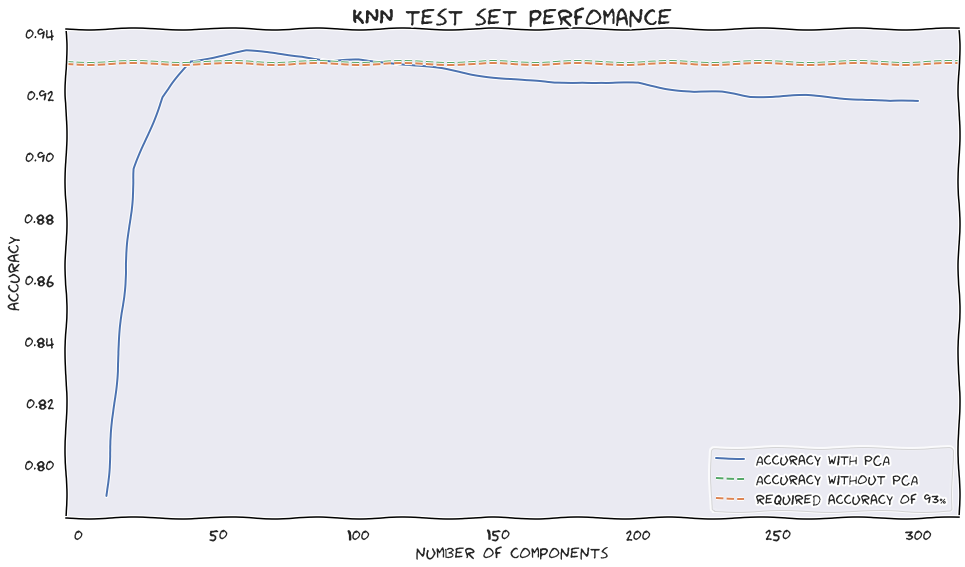

In [35]:
# >>> your solution here <<<
vanilla_accuracy = accuracy_score(y_test, preds)
n_components_space = np.arange(10, 301, 10)

explained_vars = []
accs = []
for n_components in n_components_space:
    pca = PCA(n_components=n_components, random_state=42)
    x_train_decomp = pca.fit_transform(x_train)
    x_test_decomp = pca.transform(x_test)
    knn.fit(x_train_decomp, y_train)
    preds = knn.predict(x_test_decomp)
    accs.append(accuracy_score(y_test, preds))
    explained_vars.append(pca.explained_variance_ratio_.sum())

plt.plot(n_components_space, accs, label='Accuracy with PCA')
plt.axhline(vanilla_accuracy, c='C2', ls='--', label='Accuracy without PCA')
plt.axhline(0.93, c='C1', ls='--', label='required accuracy of 93%')
plt.title('kNN test set perfomance', fontsize=24)
plt.xlabel('number of components', fontsize=16)
plt.ylabel('accuracy', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)
plt.show()

### Comment
Sorry, accuracy without pca is obviously plotted wrongly, as it should be 0.91, but the cell works too long to rerun it only for this.

In [36]:
# >>> your solution here <<<
pca = PCA(n_components=60, random_state=42)
x_train_decomp = pca.fit_transform(x_train)
x_test_decomp = pca.transform(x_test)
knn.fit(x_train_decomp, y_train)
preds = knn.predict(x_test_decomp)
accuracy = accuracy_score(y_test, preds)
print(f'kNN accuracy with PCA: {accuracy}')

np.savetxt('train_decomp.csv', x_train_decomp[:,:3], delimiter=',')
### END Solution

kNN accuracy with PCA: 0.9342


#### Voilla! you are done, have a good day ;)